In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchinfo
import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import Compose, ToTensor, Resize, Lambda

import numpy as np
import math

from typing import TypedDict, List, Dict, Any, Tuple, Optional
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from lightning.fabric import Fabric

In [2]:
fabric = Fabric()
fabric.launch()

In [3]:
class CFG():
    image_size = 32
    num_difussion_steps: int = 1000
    epochs: int = 20
    batch_size: int = 128
    lr: float = 1e-3
    time_dim_mult: int = 8
    resnet_block_groups: int = 4
    model_ema_steps: int = 10
    model_ema_decay: float = 0.995

    beta_start: float = 1e-4
    beta_end: float = 0.02

img_transform = Compose([
    Resize(CFG.image_size),
    ToTensor(),
    Lambda(lambda x: x * 2.0 - 1.0)
])

In [4]:
def extract_to_tensor(
    x: np.ndarray, timesteps: torch.Tensor, target: torch.Tensor
) -> torch.Tensor:
    extracted = torch.from_numpy(x).to(target)[timesteps]

    while extracted.dim() < target.dim():
        extracted = extracted[..., None]

    return extracted

class GaussianDiffusor:

    def __init__(self, cfg: CFG):
        self.cfg = cfg

        self.betas = self.get_betas_cos(cfg.num_difussion_steps)

        self.alphas = 1 - self.betas
        self.alphas_sqrt = np.sqrt(self.alphas)
        self.alphas_cum_prod = np.cumprod(self.alphas)
        self.alphas_cum_prod_sqrt = np.sqrt(self.alphas_cum_prod)
        self.one_minus_alphas_cum_prod_sqrt = np.sqrt(1 - self.alphas_cum_prod)
        self.one_minus_alphas_cum_prod = 1 - self.alphas_cum_prod
        self.alphas_cumprod_prev = np.concatenate(
            [np.array([1]), self.alphas_cum_prod[:-1]]
        )
        self.one_minus_alphas_cumprod_prev = 1 - self.alphas_cumprod_prev
        self.posterior_mean_coef1 = 1 / self.alphas_sqrt
        self.posterior_mean_coef2 = self.betas / self.one_minus_alphas_cum_prod_sqrt
        self.posterior_variance_beta_sqrt = self.betas ** 1/2
        self.posterior_variance_beta_hat = (self.one_minus_alphas_cumprod_prev / self.one_minus_alphas_cum_prod * self.betas) ** 1/2

    def get_betas(self, num_difussion_steps: int):
        beta_start = 1e-4
        beta_end = 0.02

        betas = np.linspace(beta_start, beta_end, num_difussion_steps)

        return betas

    def get_betas_cos(self, num_difussion_steps: int, s: float = 0.008):
        f_t = (
            np.cos(
                (
                    np.linspace(0, num_difussion_steps, num=num_difussion_steps + 1)
                    / num_difussion_steps
                    + s
                )
                / (1 + s)
                * math.pi
                / 2
            )
            ** 2
        )

        alphas = f_t[1:] / f_t[:num_difussion_steps]
        betas = 1 - alphas

        return np.clip(betas, 0, 0.999)

    @torch.no_grad()
    def q_sample(
        self, x: torch.Tensor, t: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # q ( x_t | x_0, t)
        means = extract_to_tensor(self.alphas_cum_prod_sqrt, t, x)
        std = extract_to_tensor(self.one_minus_alphas_cum_prod_sqrt, t, x)

        noise = torch.randn_like(x, device=x.device, dtype=x.dtype)

        return x * means + noise * std, noise

    @torch.no_grad()
    def p_sample_loop(
        self, model: nn.Module, n: int = 1, variance="beta_hat"
    ) -> torch.Tensor:
        # p (x_0 | x_t ) -> p ( x_{t-1} | x_t, t)
        img = torch.randn(n, 1, CFG.image_size, CFG.image_size)
        img = fabric.to_device(img)

        indices = tqdm(reversed(range(0, self.cfg.num_difussion_steps)), desc="Sampling", total=self.cfg.num_difussion_steps)

        for i in indices:
            t = torch.tensor([i])
            t = fabric.to_device(t)

            predicted_noise = model(img, t)

            posterior_mean = extract_to_tensor(self.posterior_mean_coef1, t, img) * (img - extract_to_tensor(self.posterior_mean_coef2, t, img) * predicted_noise)
            if variance == "beta_sqrt":
                posterior_variance = extract_to_tensor(self.posterior_variance_beta_sqrt, t, img)
            elif variance == "beta_hat":
                posterior_variance = extract_to_tensor(self.posterior_variance_beta_hat, t, img)

            noise = torch.randn_like(img)
            non_zero_mask = (t != 0).float().view(-1, *([1] * (len(img.shape) - 1)))
            img = posterior_mean + non_zero_mask * posterior_variance * noise

        img = torch.clamp(img, -1, 1)
        img = (img + 1) / 2
        return img

In [5]:
from typing import Callable, Optional, TypeVar, Union
from einops import reduce, rearrange
from einops.layers.torch import Rearrange
from functools import partial
from torch import einsum


def convert_module_to_f16(l):
    """
    Convert primitive modules to float16.
    """
    if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Conv3d)):
        l.weight.data = l.weight.data.half().bfloat16()
        if l.bias is not None:
            l.bias.data = l.bias.data.half().bfloat16()


T = TypeVar('T')

def exists(x: Optional[T]) -> bool:
    return x is not None

def default(val: Optional[T], d: Union[T, Callable[[], T]]) -> T:
    if exists(val):
        return val # type: ignore
    else:
        return d() if callable(d) else d

def num2groups(num, divisor):
    groups = [divisor] * (num // divisor)
    if num % divisor != 0:
        groups.append(num % divisor)
    return groups

class ResBlock(nn.Module):
    def __init__(self, fn: nn.Module):
        super().__init__()
        self.fn = fn

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        return x + self.fn(x, *args, **kwargs)

def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

def Upsample(dim: int, out_dim: Optional[int]) -> nn.Module:
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(dim, default(out_dim, dim), 3, padding=1),
    )

class SinusoidalPositionlEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings


class WeightedStandarizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, 'o c h w -> o 1 1 1', reduction='mean')
        var = reduce(weight, 'o c h w -> o 1 1 1', reduction=partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups
        )

class Block(nn.Module):
    def __init__(self, dim: int, dim_out: Optional[int] = None, groups: int = 8):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.proj = WeightedStandarizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x: torch.Tensor, scale_shift: Optional[torch.Tensor] = None) -> torch.Tensor:
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift # type: ignore
            x = x * (scale + 1) + shift

        return self.act(x)

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim: int, dim_out: int, time_emb_dim: Optional[int] = None, groups: int = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2)) # type: ignore
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups)
        self.block2 = Block(dim_out, dim_out, groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None) -> torch.Tensor:
        scale_shift = None
        if exists(t) and exists(self.mlp):
            time_emb = self.mlp(t) # type: ignore
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift)
        h = self.block2(h)
        return self.res_conv(x) + h

class Attention(nn.Module):
    def __init__(self, dim: int, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim: int, heads: int = 4, dim_head: int = 4):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            nn.GroupNorm(1, dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-1)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = einsum("b h d n, b h e n -> b h d e", k, v)

        out = einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim: int, fn: nn.Module):
        super().__init__()
        self.norm = nn.GroupNorm(1, dim)
        self.fn = fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fn(self.norm(x))

class Unet(nn.Module):

    def __init__(
        self,
        dim: int,
        init_dim: Optional[int] = None,
        out_dim: Optional[int] = None,
        dim_mults=(1, 2, 4),
        channels=1,
        self_condition=False,
        resnet_block_groups=CFG.resnet_block_groups,
        time_dim_mult=CFG.time_dim_mult,
    ):
        super().__init__()

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0)

        dims = [init_dim, *map(lambda d: dim * d, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_class = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * time_dim_mult

        self.time_mlp = nn.Sequential(
            SinusoidalPositionlEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_class(dim_in, dim_in, time_dim),
                        block_class(dim_in, dim_in, time_dim),
                        ResBlock(PreNorm(dim_in, LinearAttention(dim_in))),
                        (
                            Downsample(dim_in, dim_out)
                            if not is_last
                            else nn.Conv2d(dim_in, dim_out, 3, padding=1)
                        ),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_class(mid_dim, mid_dim, time_dim)
        self.mid_attn = ResBlock(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_class(mid_dim, mid_dim, time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_class(dim_out + dim_in, dim_out, time_dim),
                        block_class(dim_out + dim_in, dim_out, time_dim),
                        ResBlock(PreNorm(dim_out, LinearAttention(dim_out))),
                        (
                            Upsample(dim_out, dim_in)
                            if not is_last
                            else nn.Conv2d(dim_out, dim_in, 3, padding=1)
                        ),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_class(dim * 2, dim, time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

        # with torch.no_grad():
        #     for param in self.final_conv.parameters():
        #         param.zero_()

    def forward(self, x: torch.Tensor, t: torch.Tensor, x_self_cond: Optional[torch.Tensor] = None):
        if self.self_condition:
            if not exists(x_self_cond):
                x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x, x_self_cond), dim=1) # type: ignore

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(t)

        h = []

        for down1, down2, attn, downsample in self.downs:
            x = down1(x, t)
            h.append(x)

            x = down2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for up1, up2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = up1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = up2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        x = self.final_conv(x)
        return x

In [6]:
# torchvision ema implementation
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device: torch.device):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [7]:
class TrainingLoop():

    def __init__(
        self,
        cfg: CFG,
        model: nn.Module,
        diffusor: GaussianDiffusor,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
    ):
        self.cfg = cfg
        optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
        model, optimizer = fabric.setup(model, optimizer)
        self.model = model
        self.optimizer = optimizer

        adjust = 1* CFG.batch_size * CFG.model_ema_steps / CFG.epochs
        alpha = 1.0 - CFG.model_ema_decay
        alpha = min(1.0, alpha * adjust)
        self.model_ema = ExponentialMovingAverage(model, device=fabric.device, decay=1.0 - alpha)

        self.diffusor = diffusor

        train_loader, val_loader = fabric.setup_dataloaders(train_loader, val_loader)
        self.train_loader = train_loader
        self.val_loader = val_loader

        self.lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.cfg.lr,
            epochs=self.cfg.epochs,
            steps_per_epoch=len(self.train_loader),
            pct_start=0.25,
            anneal_strategy='cos'
        )

    def train(self):
        it = tqdm(range(self.cfg.epochs * len(self.train_loader)), desc="Epochs", position=0)

        global_step = 0

        for epoch in range(self.cfg.epochs):
            epoch_losses = []

            self.model_ema.train()

            for i, batch in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                loss = self.compute_loss(batch[0])
                fabric.backward(loss)
                self.optimizer.step()
                self.lr_scheduler.step()

                global_step += 1
                if global_step % self.cfg.model_ema_steps == 0:
                    self.model_ema.update_parameters(self.model)

                it.set_postfix({"loss": loss.item()})
                it.update()

                epoch_losses.append(loss.item())

            epoch_loss = np.mean(epoch_losses)
            print(f"Epoch {epoch} loss: {epoch_loss}")

            self.model_ema.eval()

            epoch_samples_beta_hat = self.diffusor.p_sample_loop(self.model_ema.module, n=100, variance="beta_hat")
            epoch_samples_beta_sqrt = self.diffusor.p_sample_loop(self.model_ema.module, n=100, variance="beta_sqrt")
            grid_beta_hat = make_grid(epoch_samples_beta_hat, nrow=10, normalize=True)
            grid_beta_square = make_grid(epoch_samples_beta_sqrt, nrow=10, normalize=True)

            fix, ax = plt.subplots(1, 2)
            ax[0].imshow(grid_beta_hat.permute(1, 2, 0).cpu().numpy())
            ax[1].imshow(grid_beta_square.permute(1, 2, 0).cpu().numpy())
            plt.show()

            plt.imsave(
                f"./images2/sample_{epoch}_beta_hat.png",
                grid_beta_hat.permute(1, 2, 0).cpu().numpy(),
            )
            plt.imsave(
                f"./images2/sample_{epoch}_beta_sqrt.png",
                grid_beta_square.permute(1, 2, 0).cpu().numpy(),
            )

        torch.save(self.model_ema.module.state_dict(), f"./models/modelpt")
        
    def compute_loss(self, BCHW_batch: torch.Tensor):
        bs = BCHW_batch.shape[0]

        t = torch.randint(0, self.cfg.num_difussion_steps, (bs,), dtype=torch.long)
        x0 = BCHW_batch

        t = fabric.to_device(t)
        x0 = fabric.to_device(x0)

        xT, noise = self.diffusor.q_sample(x0, t)
        x0_pred = self.model(xT, t, None)
        loss = F.mse_loss(x0_pred, noise)

        return loss

In [8]:
mnist_data_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=img_transform,)

mnist_data_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=img_transform,)

In [9]:
diffusor = GaussianDiffusor(CFG())
model = Unet(32, channels=1)
model = fabric.to_device(model)

total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total Trainable Params: {total_trainable_params}")

Total Trainable Params: 2809089


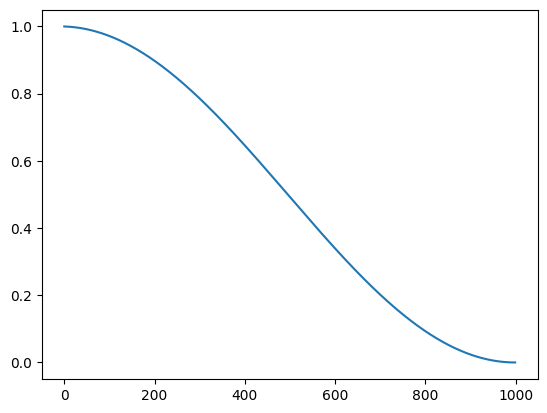

In [10]:
plt.plot(diffusor.alphas_cum_prod)
plt.show()

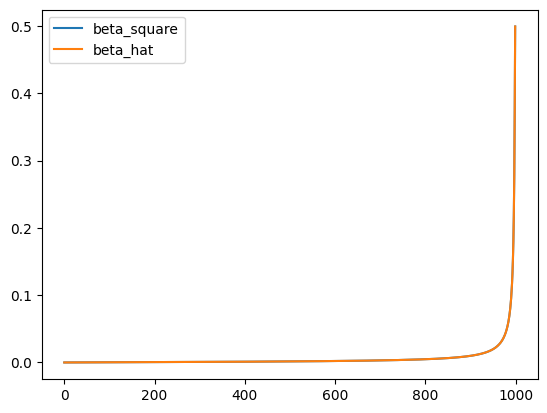

In [11]:
plt.plot(diffusor.posterior_variance_beta_sqrt, label="beta_square")
plt.plot(diffusor.posterior_variance_beta_hat, label="beta_hat")
plt.legend()
plt.show()

In [12]:
train_loader = torch.utils.data.DataLoader(mnist_data_train, batch_size=CFG.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_data_test, batch_size=CFG.batch_size, shuffle=False)

training_loop = TrainingLoop(
    CFG(),
    model,
    diffusor,
    train_loader,
    val_loader,
)

Epochs:   0%|          | 0/9380 [00:00<?, ?it/s]

Epoch 0 loss: 0.14343749515728146


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

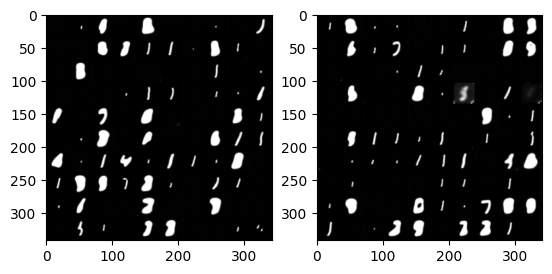

Epoch 1 loss: 0.046674441025931955


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

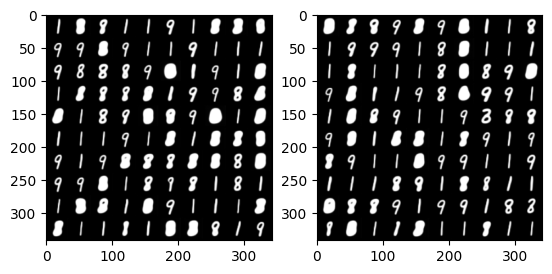

Epoch 2 loss: 0.03807212996568634


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

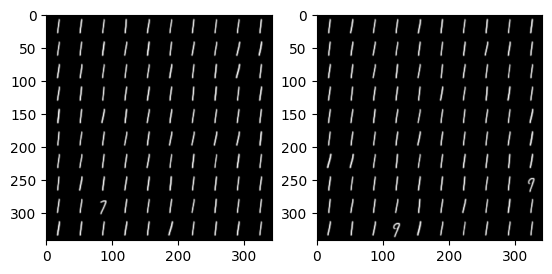

Epoch 3 loss: 0.0345561459485783


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

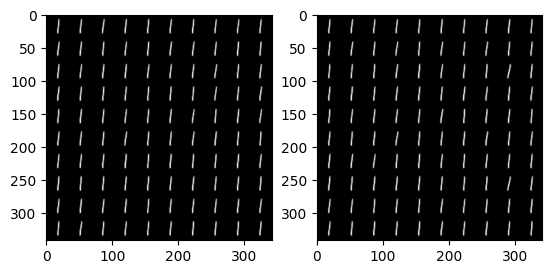

Epoch 4 loss: 0.03193065229811267


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

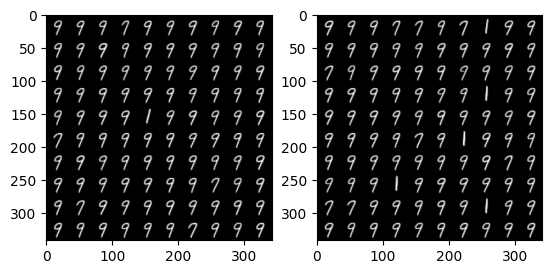

Epoch 5 loss: 0.02997100470798102


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

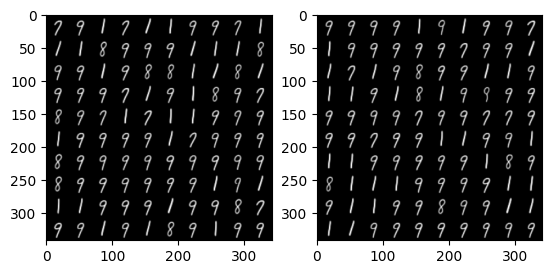

Epoch 6 loss: 0.02927387177721778


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

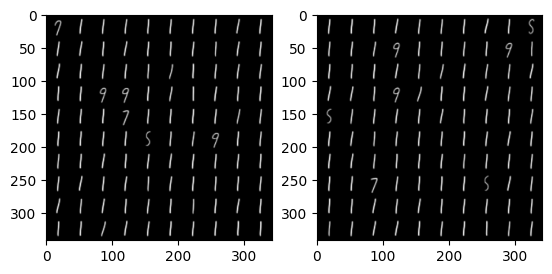

Epoch 7 loss: 0.028319371590164424


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

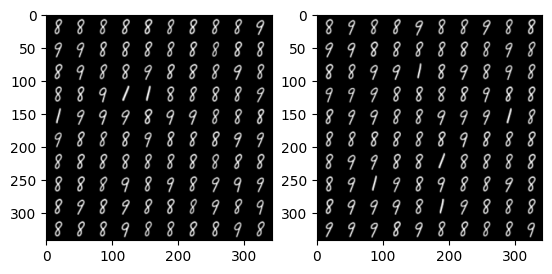

Epoch 8 loss: 0.02785533440233802


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

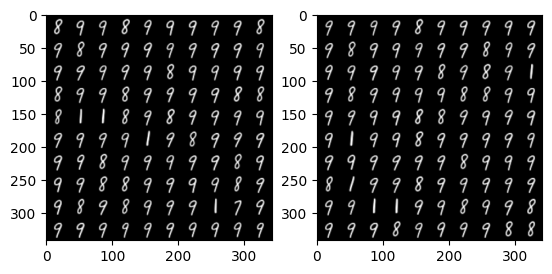

Epoch 9 loss: 0.02761307523560041


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

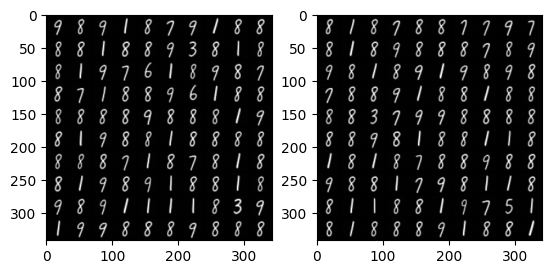

Epoch 10 loss: 0.027095163804985313


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

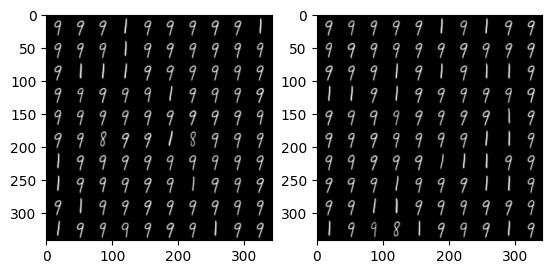

Epoch 11 loss: 0.02651652597637573


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

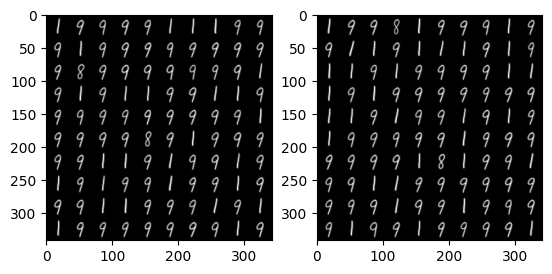

Epoch 12 loss: 0.02623127486660028


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

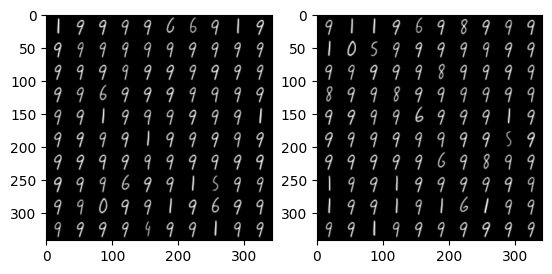

Epoch 13 loss: 0.02595555102393063


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

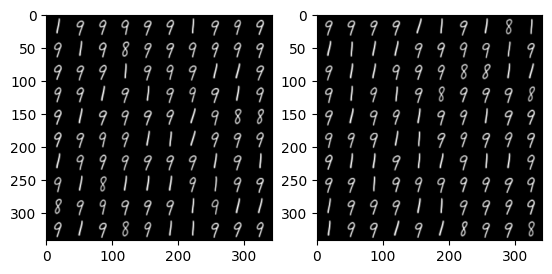

Epoch 14 loss: 0.025715145943706223


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

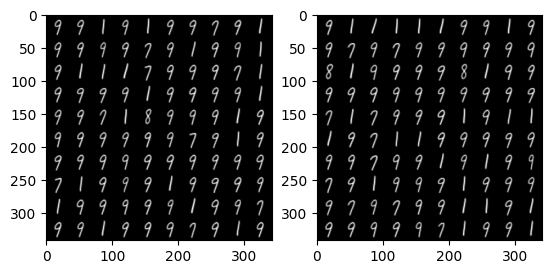

Epoch 15 loss: 0.025390889900706724


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

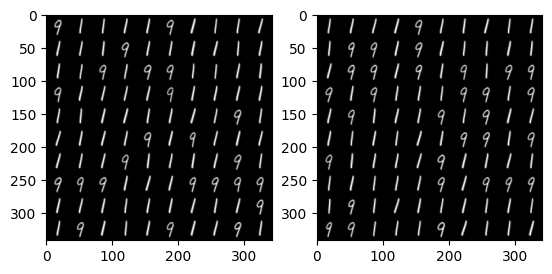

Epoch 16 loss: 0.02518616770423933


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

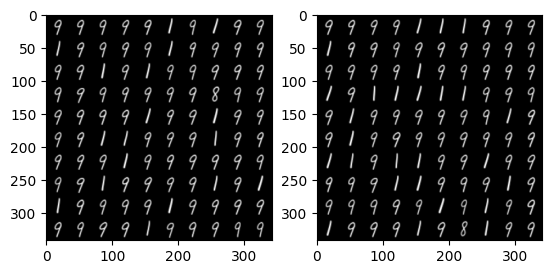

Epoch 17 loss: 0.02497347954636825


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

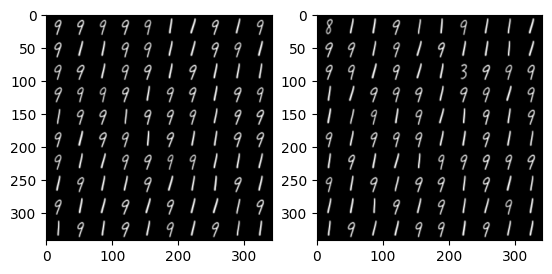

Epoch 18 loss: 0.02505994518237836


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

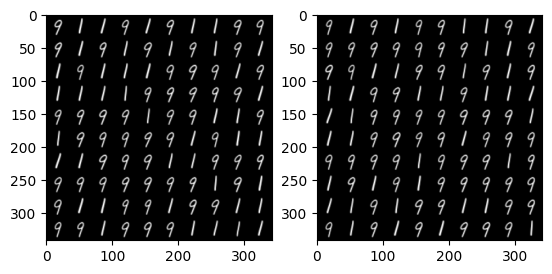

Epoch 19 loss: 0.02475436998884688


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

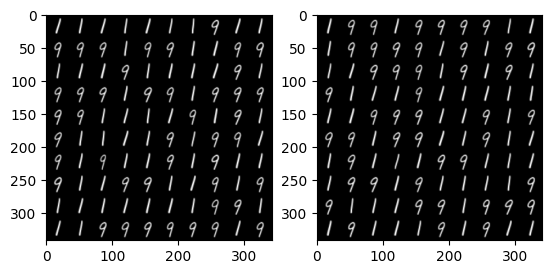

In [13]:
training_loop.train()